In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as st

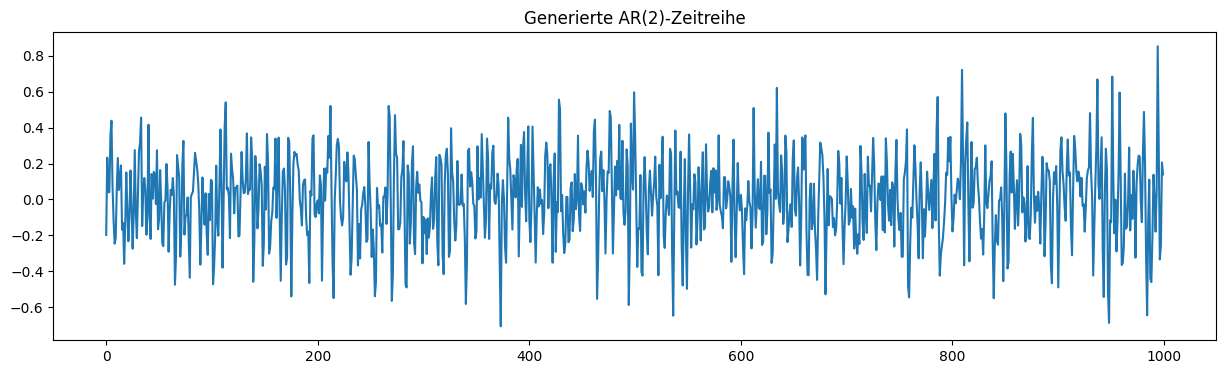

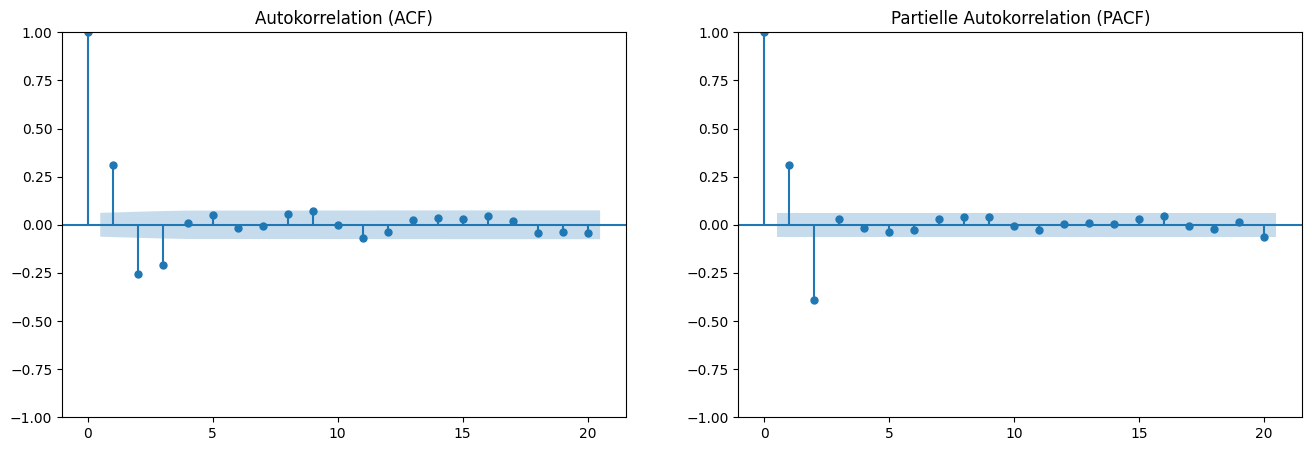

In [5]:
N = 1000 # Länge der Zeitreihe
k = 2    # Ordnung des AR-Prozesses

random.seed(42) 
x = pd.Series(np.random.normal(0, 1, N + k)) 

# Erzeuge die AR(2)-Struktur
for i in range(k, N + k):
    x[i] = 0.4 * x[i-1] - 0.4 * x[i-2] + 0.2 * x[i]

# Entferne die ersten k Werte, für die das Modell noch nicht galt
x = x[k:]
x.reset_index(drop=True, inplace=True)

# Plotten wir die generierte Zeitreihe
plt.figure(figsize=(15, 4))
plt.plot(x)
plt.title("Generierte AR(2)-Zeitreihe")
plt.show()

# ACF und PACF für diese saubere Zeitreihe berechnen und plotten
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(x, lags=20, ax=axes[0])
plot_pacf(x, lags=20, ax=axes[1])
axes[0].set_title('Autokorrelation (ACF)')
axes[1].set_title('Partielle Autokorrelation (PACF)')
plt.show()

**Interpretation des Kontrollexperiments**

Das Ergebnis ist genau wie erwartet:

- ACF (links): Klingt langsam, wellenförmig ab.
- PACF (rechts): Zeigt signifikante Korrelationen bei Lag 1 und Lag 2 und bricht danach abrupt ab (alle weiteren Balken sind innerhalb des blauen Konfidenzintervalls).

**Fazit**: Die statsmodels-Funktionen plot_acf und plot_pacf funktionieren für eine einzelne, kontinuierliche Zeitreihe perfekt.

___

**2. Simulation des realen Problems: Aufteilung in "User"**

Jetzt simulieren wir das Problem aus der Praxis. Wir nehmen unsere lange Zeitreihe und tun so, als ob sie aus vielen kurzen, voneinander unabhängigen Zeitreihen verschiedener "User" besteht. Wir fügen eine user-Spalte hinzu, die immer dann hochzählt, wenn zufällig ein "User-Wechsel" stattfindet.

In [16]:
df = pd.DataFrame({"x": x})

df['user'] = pd.Series(random.choices([0,1], weights=[0.95, 0.05], k=N)).cumsum()

**Das Problem**: Wenn wir jetzt plot_acf(df['x']) aufrufen würden, würde die Funktion fälschlicherweise z.B. den letzten Wert von User 0 mit dem ersten Wert von User 1 korrelieren. Das ist falsch und muss verhindert werden.

___
## 3. Lösungsansätze und ihre Tücken

Im Folgenden untersuchen wir die drei Ansätze aus der Vorlesung.

___
#### 3.1 Ansatz 1: Der robuste Weg - groupby().shift()

**Die Idee**:
Der eleganteste Weg, um das Problem der User-Grenzen zu lösen, ist, pandas explizit anzuweisen, Operationen nur innerhalb jeder User-Gruppe durchzuführen. Wir wollen für die Korrelationsberechnung Spalten mit den Werten der Vortage erstellen (sog. Lag-Features).

Ein einfaches df['x'].shift(1) würde am Anfang der Daten von User 2 fälschlicherweise den letzten Wert von User 1 nehmen.
Die Kombination df.groupby('user')['x'].shift(1) ist die Lösung. Sie führt die shift-Operation für jeden User getrennt aus. Am Anfang eines neuen Users wird korrekterweise ein NaN (Not a Number) erzeugt.
Nachdem wir diese "sicheren" Lag-Spalten erstellt haben, können wir die Autokorrelation einfach als die Korrelation zwischen der Originalspalte x und den verschobenen Spalten x_lag_k berechnen.

In [19]:
# --- Schritt 4: Lag-Features User-spezifisch erstellen ---
df_u = df.copy()

# Erstelle für die Lags 1 bis 5 jeweils eine neue, User-spezifisch verschobene Spalte
for lag in range(1, 6):
    df_u[f"x_lag_{lag}"] = df_u.groupby("user")["x"].shift(lag)

df_u.head(25)

,x,user,x_lag_1,x_lag_2,x_lag_3,x_lag_4,x_lag_5
0,-0.365281,0,NaN,NaN,NaN,NaN,NaN
1,0.534732,0,-0.365281,NaN,NaN,NaN,NaN
2,0.211298,0,0.534732,-0.365281,NaN,NaN,NaN
3,-0.276411,0,0.211298,0.534732,-0.365281,NaN,NaN
4,-0.568991,0,-0.276411,0.211298,0.534732,-0.365281,NaN
5,-0.061397,0,-0.568991,-0.276411,0.211298,0.534732,-0.365281
6,-0.109370,0,-0.061397,-0.568991,-0.276411,0.211298,0.534732
7,-0.063983,0,-0.109370,-0.061397,-0.568991,-0.276411,0.211298
8,0.242736,1,NaN,NaN,NaN,NaN,NaN
9,0.118608,1,0.242736,NaN,NaN,NaN,NaN


jetzt, da wir eine saubere Tabelle haben, in der jede Zeile die benötigten historischen Werte enthält (oder NaN, falls nicht verfügbar), können wir die Korrelationen berechnen.

In [21]:
acf_via_shift = df_u.drop(columns=["user"]).corr()["x"]
print(acf_via_shift)

x          1.000000
x_lag_1    0.312709
x_lag_2   -0.304759
x_lag_3   -0.285692
x_lag_4    0.044328
x_lag_5    0.181163
Name: x, dtype: float64


**Interpretation und Fazit zu Ansatz 1**

**Ergebnis:**
Wir erhalten eine Schätzung für die Autokorrelation bei den Lags 1 bis 5. Diese Werte sind unsere beste Annäherung an die wahre Korrelationsstruktur, gemittelt über alle User.

**Vorteile:**

**Methodisch korrekt:** Es wird garantiert nicht über User-Grenzen hinweg gerechnet.
Flexibel: Dieser Ansatz legt die Grundlage für fast jedes Feature Engineering, das auf historischen Daten basiert.
Nachteil (wie in der Vorlesung erwähnt):

**Aufwand für PACF:** Während die ACF so elegant berechnet werden kann, ist die Berechnung der PACF sehr aufwendig. Man müsste nun manuell eine Serie von linearen Regressionen durchführen, um die partiellen Autokorrelationen zu bestimmen, da es keine eingebaute statsmodels-Funktion gibt, die dieses Format direkt unterstützt.
**Fazit:** Dieser Ansatz ist der "Goldstandard" und der konzeptionell sauberste Weg.

_________________________________

#### 3.2 Ansatz 2: Die "trügerische" Alternative - groupby().apply()

**Die Idee**:
Dieser Ansatz klingt auf den ersten Blick sehr logisch: Wenn wir die durchschnittliche Autokorrelation über alle User wollen, warum nicht einfach für jeden User einzeln die statsmodels-Autokorrelationsfunktion (st.acf) anwenden und dann die Ergebnisse mitteln?

Wir werden sehen, dass dieser Weg zu inkorrekten Ergebnissen führt.

In [31]:
# --- Schritt 6 (Überarbeitet): ACF pro User-Gruppe berechnen und mitteln ---
def autocorr_by_group(df, lags=5):
    grouped = df.groupby('user')['x']
    
    autocorrelations = grouped.apply(lambda s: st.acf(s, nlags=lags)[1:] if len(s) > lags else None)
    
    return autocorrelations.dropna()

# Berechne die ACFs für jeden User, der eine ausreichend lange Reihe hat
autocorr_per_user = autocorr_by_group(df_u, lags=5)

# Robuste Mittelwertbildung:
acf_via_apply_values = np.vstack(autocorr_per_user.values).mean(axis=0)

acf_via_apply = pd.Series(acf_via_apply_values, index=[f'x_lag_{i+1}' for i in range(5)])


print("--- Vergleich der Ergebnisse ---")
print("\nGeschätzte Autokorrelationen (Ansatz 1 - groupby.shift):")
print(acf_via_shift[1:]) 

print("\nGeschätzte Autokorrelationen (Ansatz 2 - groupby.apply, korrigiert):")
print(acf_via_apply)

--- Vergleich der Ergebnisse ---

Geschätzte Autokorrelationen (Ansatz 1 - groupby.shift):
x_lag_1    0.312709
x_lag_2   -0.304759
x_lag_3   -0.285692
x_lag_4    0.044328
x_lag_5    0.181163
Name: x, dtype: float64

Geschätzte Autokorrelationen (Ansatz 2 - groupby.apply, korrigiert):
x_lag_1    0.199788
x_lag_2   -0.296682
x_lag_3   -0.227255
x_lag_4   -0.026760
x_lag_5    0.017588
dtype: float64


**Interpretation und Erklärung des Problems**

Beobachtung:
Die mit Ansatz 2 berechneten Korrelationswerte sind deutlich niedriger (näher an null) als die Werte aus dem robusten Ansatz 1. Dieser Ansatz unterschätzt die wahre Korrelation massiv.

Erklärung (Der Grund für das Scheitern):
Das Problem liegt in einer fundamentalen statistischen Eigenschaft der Autokorrelations-Schätzung:

Statistischer Bias bei kurzen Zeitreihen: Die mathematische Formel zur Schätzung der Autokorrelation ist ein sogenannter "biased estimator" (verzerrter Schätzer). Auf kurzen Zeitreihen neigt sie dazu, die wahre Stärke der Korrelation systematisch zu niedrig zu schätzen (ein "Bias" in Richtung null). Die Schätzung wird erst bei langen Zeitreihen zuverlässig.

Fehler durch Mittelung: Unsere User-Segmente sind überwiegend kurz. Wenn wir st.acf auf jedes dieser kurzen Segmente anwenden, erhalten wir viele einzelne, bereits verzerrte (zu niedrige) Schätzungen.

Fazit: Indem wir den Durchschnitt über viele systematisch zu niedrige Schätzungen bilden, erhalten wir ein Endergebnis, das ebenfalls systematisch zu niedrig und somit falsch ist.

Dieser Ansatz ist daher methodisch ungeeignet für dieses Problem. Er illustriert perfekt, wie wichtig das Verständnis für die Grenzen statistischer Funktionen ist.

___
#### 3.3 Ansatz 3: Die "Sackgasse" für PACF - Padding mit NaNs

Die Idee:

Dieser Ansatz versucht, die groupby-Operation komplett zu umgehen. Die Idee ist, bei der langen, zusammenhängenden Zeitreihe zu bleiben, aber "Trennstreifen" oder "Puffer" zwischen den einzelnen Usern einzufügen. Wenn dieser Puffer aus NaN-Werten besteht, so die Hoffnung, werden die statsmodels-Funktionen keine Korrelationen über die User-Grenzen hinweg berechnen.

Wichtig dabei: 

Der Puffer muss mindestens so lang sein wie der maximale Lag, den wir betrachten wollen. Für lags=5 benötigen wir also mindestens 5 NaN-Zeilen als Puffer.

In [32]:
# --- Schritt 8: Puffer aus NaNs zwischen Usern einfügen ---
df_pad = df[['user', 'x']].copy()
max_lags = 5

# Finde die Indizes, an denen ein User-Wechsel stattfindet
user_changes = df_pad['user'].diff() != 0
# Wir nehmen alle Indizes außer dem ersten (der immer bei 0 ist)
user_change_indices = df_pad[user_changes].index.tolist()[1:]

# Erstelle ein DataFrame mit 5 leeren (NaN) Zeilen
nan_df = pd.DataFrame([[np.nan, np.nan]] * max_lags, columns=df_pad.columns)

# Iteriere rückwärts durch die Wechsel-Indizes und füge die NaN-Zeilen ein
# (Rückwärts, damit die Indizes der früheren Wechsel gültig bleiben)
for index in reversed(user_change_indices):
    df_pad = pd.concat([df_pad.iloc[:index], nan_df, df_pad.iloc[index:]]).reset_index(drop=True)

print(f"DataFrame nach dem Einfügen von {max_lags} NaN-Zeilen bei jedem User-Wechsel:")
# Zeige einen Bereich, in dem ein User-Wechsel stattgefunden hat
df_pad.head(30)

DataFrame nach dem Einfügen von 5 NaN-Zeilen bei jedem User-Wechsel:


,user,x
0,0.0,-0.365281
1,0.0,0.534732
2,0.0,0.211298
3,0.0,-0.276411
4,0.0,-0.568991
5,0.0,-0.061397
6,0.0,-0.109370
7,0.0,-0.063983
8,NaN,NaN
9,NaN,NaN


**Test des Padding-Ansatzes**
Nun prüfen wir, ob die acf- und pacf-Funktionen mit dieser gepaddeten Zeitreihe umgehen können.

Für die ACF: Die Funktion st.acf hat ein missing-Argument. Mit missing='conservative' werden bei der Berechnung Paare ignoriert, bei denen mindestens ein Wert NaN ist. Das sollte funktionieren.

In [33]:
# --- Schritt 9: ACF auf der gepaddeten Reihe berechnen ---

# Wir erwarten, dass dies funktioniert und ähnliche Ergebnisse wie Ansatz 1 liefert
try:
    autocorr_padded = st.acf(df_pad.x.dropna(how='all'), nlags=5, missing="conservative")
    print("ACF mit Padding (missing='conservative'):\n", autocorr_padded[1:])
except Exception as e:
    print(f"Ein Fehler ist aufgetreten: {e}")

# --- Schritt 10: Versuch, die PACF zu berechnen ---
print("\nVersuch, die PACF zu berechnen...")
try:
    # Diese Funktion wird einen Fehler werfen oder falsche Ergebnisse liefern,
    # da sie nicht mit NaNs umgehen kann und keinen 'missing'-Parameter hat.
    pacf_padded = st.pacf(df_pad.x, nlags=5)
    print("PACF (potenziell fehlerhaft):\n", pacf_padded[1:])
except Exception as e:
    print(f"Ein erwarteter Fehler ist aufgetreten: {e}")

ACF mit Padding (missing='conservative'):
 [ 0.30513374 -0.31188157 -0.279159    0.03892319  0.166985  ]

Versuch, die PACF zu berechnen...
PACF (potenziell fehlerhaft):
 [nan nan nan nan nan]


**Ergebnis und Fazit zu Ansatz 3**

Das Problem:

Während der Trick für die ACF mit dem richtigen Parameter funktioniert, scheitert der Ansatz bei der PACF. Die Funktion statsmodels.tsa.stattools.pacf besitzt keine Option, um mit fehlenden Werten (NaNs) umzugehen.

Sie würde entweder einen Fehler erzeugen oder, schlimmer noch, die NaNs ignorieren und doch wieder über die User-Grenzen hinweg rechnen, was zu falschen Ergebnissen führt.

Fazit: Dieser Ansatz ist eine technische Sackgasse, da die für die Modellidentifikation oft entscheidende PACF damit nicht korrekt berechnet werden kann.

___

#### 4. Resümee: Welcher Ansatz ist der richtige?

Wir haben drei Methoden zur Berechnung von Korrelationen in Panel-Daten untersucht und verglichen. Die Ergebnisse sind eindeutig:

- Ansatz 1 (groupby().shift()): Dies ist der methodisch sauberste und robusteste Weg. Er stellt sicher, dass alle Berechnungen strikt innerhalb der User-Grenzen stattfinden. Er liefert die korrekte Basis für die Berechnung der ACF (über .corr()) und wäre auch die richtige Grundlage für eine manuelle Implementierung der PACF. Dies ist der empfohlene Ansatz.

- Ansatz 2 (groupby().apply(acf)): Dieser Ansatz ist statistisch fehlerhaft. Er liefert systematisch zu niedrige Korrelationswerte, da die ACF-Schätzung auf kurzen Zeitreihen unzuverlässig und verzerrt ist. Nicht verwenden!

- Ansatz 3 (Padding mit NaNs): Dieser Ansatz ist aufgrund von technischen Limitierungen der statsmodels-Bibliothek unvollständig. Er funktioniert zwar für die ACF, scheitert aber an der PACF und ist daher für eine vollständige Analyse unbrauchbar.

Für eine verlässliche Analyse, die sowohl ACF als auch PACF benötigt, führt also kein Weg an der sauberen Datenaufbereitung mit der groupby().shift()-Methode vorbei.